# RFM 분석
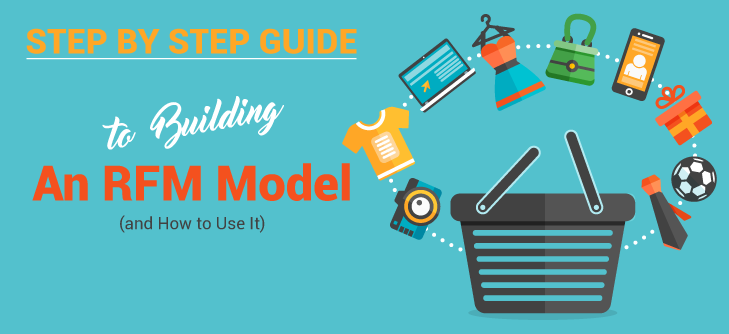

RFM 분석은 `CRM(고객 관계 관리)` 분야에서 고객의 가치를 분석하는데 사용되는 분석방법이다.

- `Recency` : 얼마나 최근에 구매하였는가? (최근성)
- `Frequency` : 얼마나 자주 구매(방문)하였는가? (행동 빈도)
- `Monetary` : 얼마나 많이 구매하였는가? (구매 금액)

In [36]:
import numpy as np 
import pandas as pd 
import datetime as dt

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# ML 알고리즘
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 오류 무시
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('/content/Online Retail.xlsx')

print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# 결측치 개수 확인
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# 결측치 있는 행 제거
df = df.dropna(subset=['CustomerID'])

In [6]:
# 결측치 제거됨
df.isnull().sum().sum()

0

In [7]:
# 중복값 확인
df.duplicated().sum()

5225

In [8]:
# 중복값 제거
df = df.drop_duplicates()

In [9]:
# 중복값 제거됨
df.duplicated().sum()

0

- min 값을 확인해보니 수량을 의미하는 Quantity에 음수가 존재한다.
- UnitPrice에 0원이 존재한다.

In [10]:
# 기술통계
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
# 음수 값과 0원 제거
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df.describe() 

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [12]:
df.shape

(392692, 8)

In [13]:
# 총 금액을 나타내는 Total Sum Column
df['TotalSum'] = df['UnitPrice'] * df['Quantity']

# Data Preparation Steps
print('Min Invoice Date : ', df.InvoiceDate.dt.date.min())
print('Max Invoice Date : ', df.InvoiceDate.dt.date.max())

df.head()

Min Invoice Date :  2010-12-01
Max Invoice Date :  2011-12-09


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [14]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [15]:
# 아래의 InvoiceDate의 lambda 계산식은 해당 값에서 day만 추출해내기 위함이다.
snapshot_date - df['InvoiceDate']

0        374 days 04:24:00
1        374 days 04:24:00
2        374 days 04:24:00
3        374 days 04:24:00
4        374 days 04:24:00
                ...       
541904     1 days 00:00:00
541905     1 days 00:00:00
541906     1 days 00:00:00
541907     1 days 00:00:00
541908     1 days 00:00:00
Name: InvoiceDate, Length: 392692, dtype: timedelta64[ns]

In [16]:
# RFM 계산
rfm = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x : (snapshot_date - x.max()).days,
                                      'InvoiceNo':'count',
                                      'TotalSum': 'sum'})
rfm = rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalSum':'MonetaryValue'})
rfm

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


In [17]:
# RFM 세그먼트 구축
r_labels = range(4, 0, -1)  # 4, 3, 2, 1
f_labels = range(1, 5)  # 1, 2, 3, 4
m_labels = range(1, 5)  # 1, 2, 3, 4

r_quartiles = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
f_quartiles = pd.qcut(rfm['Frequency'], q=4, labels=f_labels)
m_quartiles = pd.qcut(rfm['MonetaryValue'], q=4, labels=m_labels)

# assign() 함수를 통해 한 번에 여러 번수를 만들 수 있음
rfm = rfm.assign(R=r_quartiles, F=f_quartiles, M=m_quartiles)

In [18]:
rfm

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,4
12347.0,2,182,4310.00,4,4,4
12348.0,75,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,310,17,334.40,1,1,2
...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1
18281.0,181,7,80.82,1,1,1
18282.0,8,12,178.05,4,1,1


In [19]:
def add_rfm(x):
    return str(str(x['R']) + str(x['F']) + str(x['M']))

In [20]:
rfm['RFM_Segment'] = rfm.apply(add_rfm,axis=1 )
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,1.01.04.0,6
12347.0,2,182,4310.00,4,4,4,4.04.04.0,12
12348.0,75,31,1797.24,2,2,4,2.02.04.0,8
12349.0,19,73,1757.55,3,3,4,3.03.04.0,10
12350.0,310,17,334.40,1,1,2,1.01.02.0,4
...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,1.01.01.0,3
18281.0,181,7,80.82,1,1,1,1.01.01.0,3
18282.0,8,12,178.05,4,1,1,4.01.01.0,6


In [21]:
rfm.groupby(['RFM_Segment']).size().sort_values(ascending=False)

RFM_Segment
4.04.04.0    450
1.01.01.0    381
3.04.04.0    217
1.02.02.0    206
2.01.01.0    179
            ... 
1.02.04.0      7
3.01.04.0      7
4.01.04.0      6
1.04.02.0      3
4.04.01.0      3
Length: 61, dtype: int64

In [22]:
# 하단 세그먼트 111 선택하고 상위 5개 보기
rfm[rfm['RFM_Segment'] == '111'].head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,


In [23]:
# RFM Score Summary
rfm.groupby('RFM_Score').agg({'Recency':'mean',
                              'Frequency':'mean',
                              'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           260.7       8.2         157.4   381
4           177.2      13.6         240.0   388
5           152.9      21.2         366.6   518
6            95.9      27.9         820.8   457
7            79.6      38.0         758.1   463
8            64.1      56.0         987.3   454
9            45.9      78.7        1795.1   414
10           32.4     110.5        2056.4   426
11           21.3     186.9        4062.0   387
12            7.2     367.8        9285.9   450

In [24]:
# RFM 점수를 사용하여 고객을 골드, 실버, 브론즈 세그먼트로 분류
def segments(df):
    if df['RFM_Score'] > 9:
        return 'Gold'
    elif df['RFM_Score'] <= 5:
        return 'Bronze'
    else:
        return 'Silver'

In [25]:
rfm['General_Segment'] = rfm.apply(segments, axis=1)

In [26]:
rfm.groupby('General_Segment').agg({'Recency':'mean',
                                    'Frequency':'mean',
                                    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            192.2      15.1         266.5  1287
Gold               20.1     225.6        5246.8  1263
Silver             72.0      49.4        1072.4  1788

K-means를 사용하기 전 다음과 같은 가정을 확인해야 한다.
- 변수의 대칭 분포(편향되지 않음)
- 평균 값이 동일한 변수
- 분산이 동일한 변수

In [27]:
rfm_rfm = rfm[['Recency','Frequency','MonetaryValue']]
print(rfm_rfm.describe())

- 평균과 분산이 동일하지 않다는 문제점을 발견하였다.
-  Scikit-learn 라이브러리의 Scaler를 사용하여 변수 크기 조정한다.

In [29]:
rfm2 = rfm[['Recency', 'Frequency', 'MonetaryValue']]
rfm2.describe()

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,92.536422,90.523744,2048.688081
std,100.014169,225.506968,8985.230220
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,306.482500
50%,51.000000,41.000000,668.570000
75%,142.000000,98.000000,1660.597500
max,374.000000,7676.000000,280206.020000


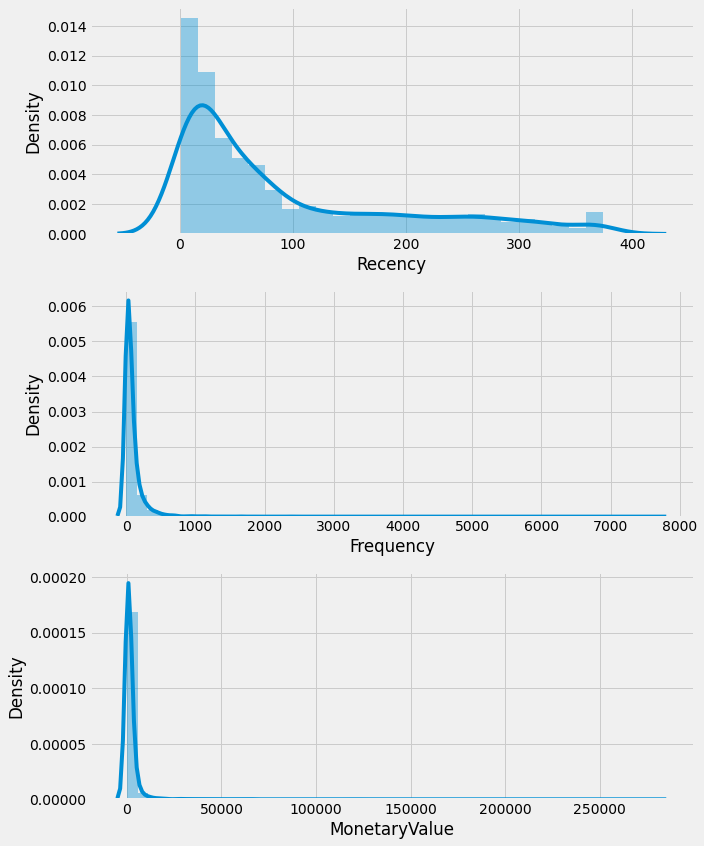

In [35]:
fig, ax = plt.subplots(figsize=(10, 12))

plt.subplot(3, 1, 1);
sns.distplot(rfm['Recency'], label='Recency')

plt.subplot(3, 1, 2);
sns.distplot(rfm['Frequency'], label='Frequency')

plt.subplot(3, 1, 3);
sns.distplot(rfm['MonetaryValue'], label='Monetary')

plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

변수의 비대칭 분포(데이터 치우침)라는 문제점도 있다.<br>
이를 해결하기 위해 로그 변환(양의 값만 해당)은 왜도를 관리한다.

다음과 같은 일련의 구조화 사전 처리 단계를 사용한다.<br>
1. 데이터 왜곡 해제 - 로그 변환
2. 동일한 평균값으로 표준화
3. 동일한 표준 편차로 조정
4. 클러스터링에 사용할 별도의 어레이로 저장

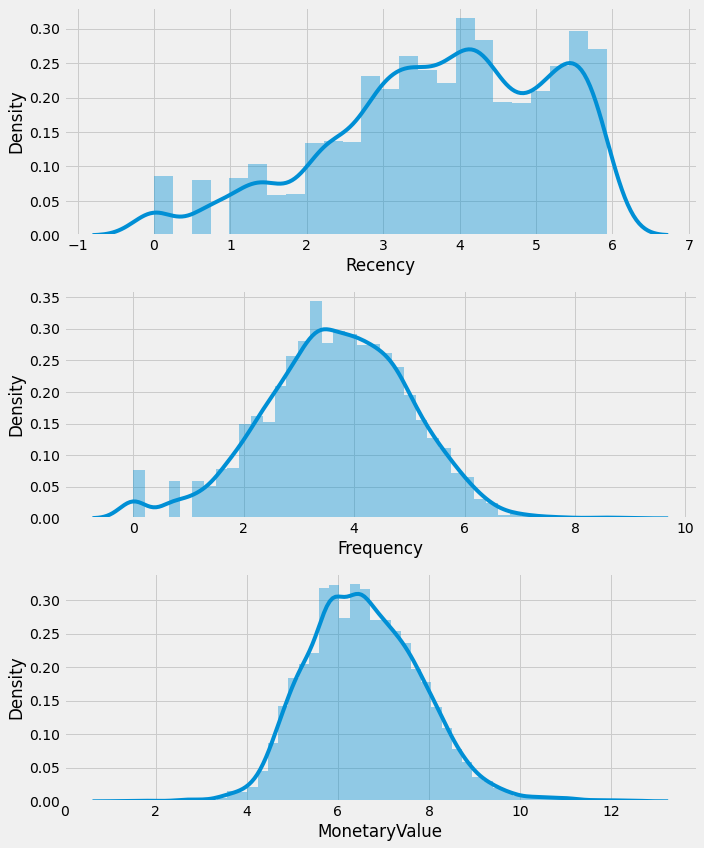

In [37]:
rfm_log = rfm[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis=1).round(3)  # 또는 rfm_log = np.log(rfm2)

# 시각화
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm_log['Recency'], label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_log['Frequency'], label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_log['MonetaryValue'], label = 'Monetary Value')

plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

- K-평균 군집화 구현

과정은 다음과 같다.
<br>

1. 데이터 전처리
2. 군집 수 선택
3. 사전 처리된 데이터에서 k-평균 군집화 실행
4. 각 클러스터의 평균 RFM 값 분석

- 데이터 전처리

In [38]:
# StandardSclaer를 이용
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rfm_log)

rfm_scaled = scaler.transform(rfm_log)

군집의 수를 정하는 방법은 다음과 같다.<br>

- 시각적 방법 - 팔꿈치 기준
- 수학적 방법 - 실루엣 계수
- 실험 및 해석

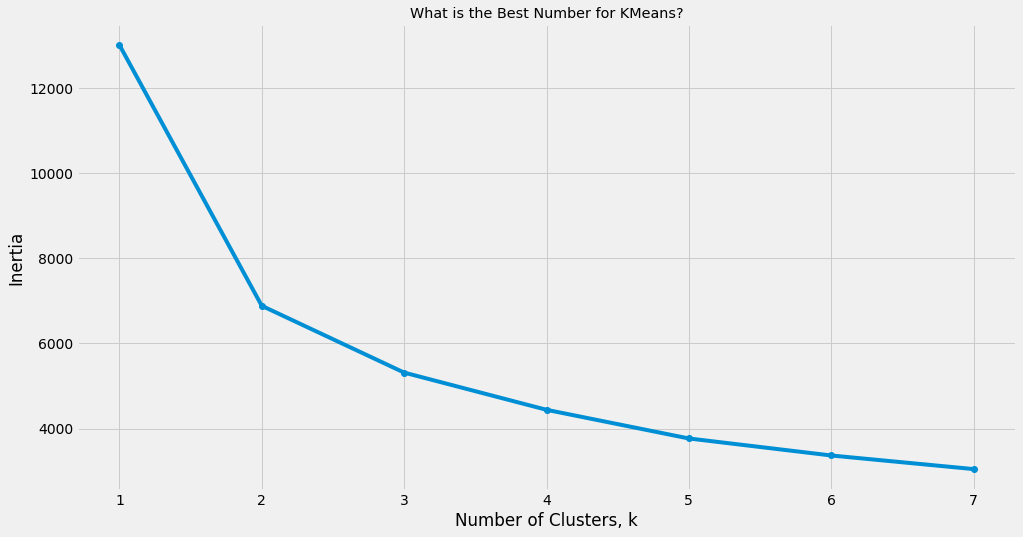

In [39]:
from sklearn.cluster import KMeans

ks = range(1, 8)
inertias = []
for k in ks:
    # Create a KMeans Clusters
    kc = KMeans(n_clusters=k, random_state=42)
    kc.fit(rfm_scaled)
    inertias.append(kc.inertia_)

# Plot ks vs inertias
fig, ax = plt.subplots(figsize=(15, 8))

plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans?')
plt.show()

- KMeans = 3으로 결정한다.

In [51]:
# 클러스터링
kc = KMeans(n_clusters=3, random_state=42)
kc.fit(rfm_scaled)

# 군집 Label 컬럼 생성
cluster_labels = kc.labels_  # 0, 1, 2

# 각 클러스터의 평균 RFM 값 및 크기 계산:
rfm_k3 = rfm2.assign(K_Cluster=cluster_labels)

rfm_k3.groupby('K_Cluster').agg({'Recency':'mean',
                                 'Frequency':'mean',
                                 'MonetaryValue':['mean', 'count']}).round(0)

Recency Frequency MonetaryValue      
             mean      mean          mean count
K_Cluster                                      
0            13.0     260.0        6575.0   952
1           170.0      15.0         293.0  1535
2            69.0      66.0        1176.0  1851

In [55]:
rfm_normalized = pd.DataFrame(rfm_scaled, index=rfm2.index, columns=rfm2.columns)
rfm_normalized['K_Cluster'] = kc.labels_
rfm_normalized['General_Segment'] = rfm['General_Segment']
rfm_normalized = rfm_normalized.reset_index()
rfm_normalized

,CustomerID,Recency,Frequency,MonetaryValue,K_Cluster,General_Segment
0,12346.0,1.409982,-2.779971,3.700239,1,Silver
1,12347.0,-2.146578,1.160365,1.413494,2,Gold
2,12348.0,0.383648,-0.179833,0.719941,1,Silver
3,12349.0,-0.574961,0.468308,0.702503,1,Gold
4,12350.0,1.375072,-0.634895,-0.613267,0,Bronze
...,...,...,...,...,...,...
4333,18280.0,1.298970,-1.036198,-1.101529,0,Bronze
4334,18281.0,0.998750,-1.306509,-1.738805,0,Bronze
4335,18282.0,-1.178892,-0.898392,-1.112626,0,Silver
4336,18283.0,-1.662735,2.202995,0.822191,2,Gold


In [60]:
rfm_melt = pd.melt(rfm_normalized,
                   id_vars=['CustomerID','General_Segment','K_Cluster'],
                   value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                   var_name='Metric',value_name='Value')
rfm_melt

,CustomerID,General_Segment,K_Cluster,Metric,Value
0,12346.0,Silver,1,Recency,1.409982
1,12347.0,Gold,2,Recency,-2.146578
2,12348.0,Silver,1,Recency,0.383648
3,12349.0,Gold,1,Recency,-0.574961
4,12350.0,Bronze,0,Recency,1.375072
...,...,...,...,...,...
13009,18280.0,Bronze,0,MonetaryValue,-1.101529
13010,18281.0,Bronze,0,MonetaryValue,-1.738805
13011,18282.0,Silver,0,MonetaryValue,-1.112626
13012,18283.0,Gold,2,MonetaryValue,0.822191


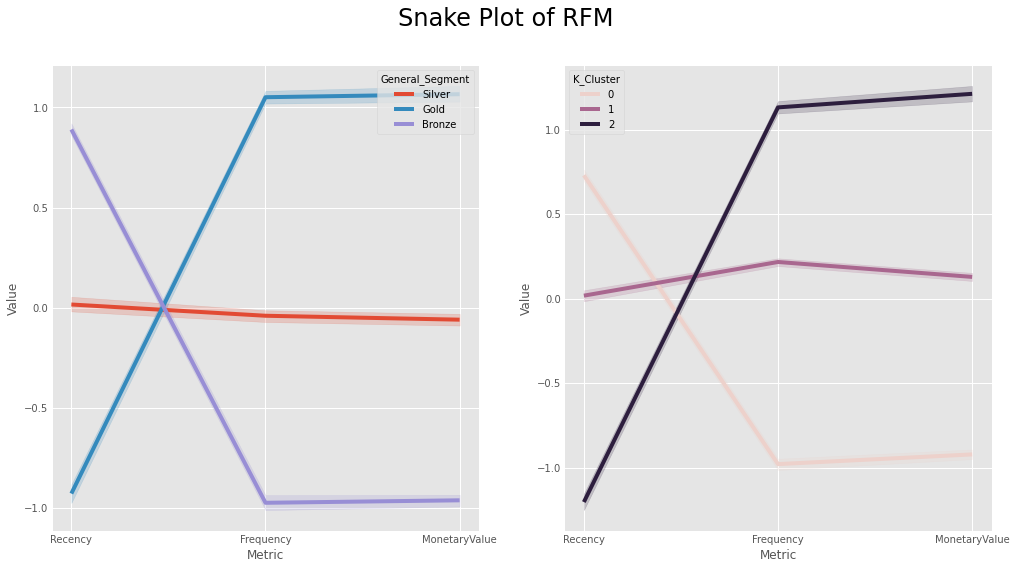

In [61]:
# 시각화
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))
sns.lineplot(x='Metric', y='Value', hue='General_Segment', data=rfm_melt, ax=ax1)
sns.lineplot(x='Metric', y='Value', hue='K_Cluster', data=rfm_melt, ax=ax2)

plt.suptitle("Snake Plot of RFM",fontsize=24) 
plt.show()

세그먼트 속성의 상대적 중요도

- 각 세그먼트 속성의 상대적 중요성을 식별하는 유용한 기술
- 각 클러스터의 평균 값 계산
- 모집단의 평균 값 계산
- 중요도 점수를 나누고 1을 빼서 계산합니다(클러스터 평균이 모집단 평균과 동일한 경우 0이 반환됨)


In [64]:
# 비율이 0에서 멀어질수록 총 모집단에 상대적인 세그먼트에 대한 속성이 더 중요하다.
cluster_avg = rfm_k3.groupby(['K_Cluster']).mean()
population_avg = rfm2.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
K_Cluster,,,
0,0.85,-0.84,-0.86
1,-0.25,-0.28,-0.43
2,-0.86,1.87,2.20


In [66]:
# 총 평균을 사용하여 비례 차이를 계산한다.
cluster_avg = rfm.groupby('General_Segment').mean().iloc[:, 0:3]
total_avg = rfm.iloc[:, 0:3].mean()
prop_rfm = cluster_avg / total_avg - 1
prop_rfm.round(2)

,Recency,Frequency,MonetaryValue
General_Segment,,,
Bronze,1.08,-0.83,-0.87
Gold,-0.78,1.49,1.56
Silver,-0.22,-0.45,-0.48


- RFM 분위수와 K-Means 클러스터링 방법으로 두 가지 종류의 세분화를 만들었다.

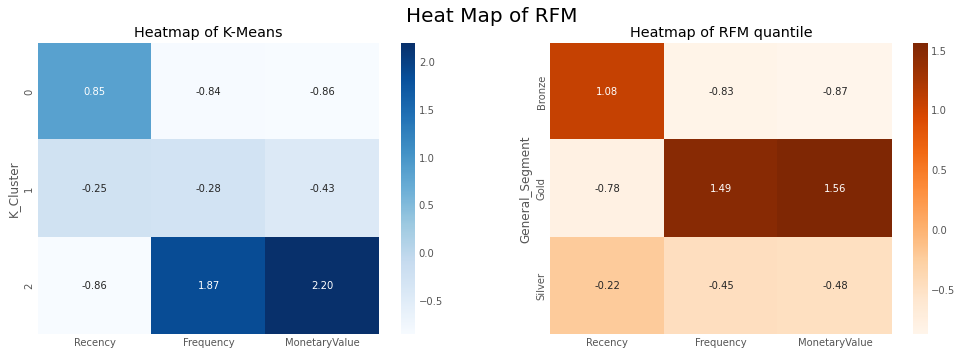

In [67]:
# heatmap with RFM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Blues',ax=ax1)
ax1.set(title = "Heatmap of K-Means")

# a snake plot with K-Means
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True,ax=ax2)
ax2.set(title = "Heatmap of RFM quantile")

plt.suptitle("Heat Map of RFM",fontsize=20) #make title fontsize subtitle 

plt.show()